# RNN in Numpy

Recurrent Neural Networks (RNN) are a class of Artificial Neural Networks that is extremely well equiped to process a sequence of inputs. Therefore, RNNs are usefull in time series. 

In this work, I created a RNN from scratch using Numpy. This RNN is based on Andrej Karpathy's char-rnn and will be the basis for a LSTM network. This network will be used to classify protein locations based on the amino acid sequence.

In [1]:
# First import numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Random seed
np.random.seed(420)

In [3]:
# Open the training data and save some important variables. If you want to train on your own text, just change the .txt file in the data variable.
#data = open('shakespeare.txt', 'r').read()
data = open('nescio.txt', 'r').read()
chars = list(set(data))
data_size = len(data)
vocab_size = len(chars)

In [4]:
print(f'Data set is length {data_size}')
print(f'Vocab set is length {vocab_size}')

Data set is length 201884
Vocab set is length 88


In [5]:
# Simple character embedding
char_to_idx = {char:i for i, char in enumerate(chars)}
idx_to_char = {i:char for i, char in enumerate(chars)}

In [6]:
# hyperparameters
hidden_size = 100
seq_length = 25
learning_rate = 1e-1
epochs = 10

In [7]:
class RNN():
    r""" Simple recurrent neural network (RNN) class for an input sequence.
    
        This RNN initializes weight and gradients. And contains the forward
        and backward pass. The network is optimized using Adagrad.
        The train method is used to train the network.
        
        Parameters
        ----------
        seq_length : Number of layers connected to each others. 
        hidden_sz : The number of features in the hidden state h.
        vocab_sz : The number of possible inputs and outputs.
        
        
        Inputs (train)
        --------------
        data : Data used to train the network.
        optimizer : The optimizer that is used to train the network.
        lr : The learning rate used to train the network.
        epochs : The number of epochs to train the network.
        progress : If True, shows the progress of training the network.
        
        Inputs (predict)
        ----------------
        start : Start of a sentence that the network uses as initial sequence.
        n : Length of the prediction.
        
        
        Output (train)
        --------------
        smooth_loss : The loss of the current trained network.
        Wxh, Whh, Why : Updated weights of the network due to training.
        bh, by : Updated biases due to training.
        
        Output (predict)
        ----------------
        txt : A string that is predicted by the RNN.
    
    """
    
    def __init__(self, seq_length, hidden_sz, vocab_sz):
        self.hs = {} # Hidden states
        self.sm_ps = {} # Softmax probabilities
        self.seq_length = seq_length
        self.hidden_sz = hidden_sz
        self.vocab_sz = vocab_sz
        
        # Start with zero loss
        self.loss = 0 
        
        # Initiate weight matrices
        self.Wxh, self.Whh, self.Why, self.bh, self.by = self.init_weights()
        
        
    def init_weights(self):
        """
        Initializes weights and biases based on the inputs hidden_sz and vocab_sz
        """
        Wxh = np.random.randn(self.hidden_sz, self.vocab_sz) * 0.01 #times 0.01 to avoid exploding gradients
        Whh = np.random.randn(self.hidden_sz, self.hidden_sz) * 0.01
        Why = np.random.randn(self.vocab_sz, self.hidden_sz) * 0.01
        
        # bias
        bh = np.zeros((hidden_size, 1))
        by = np.zeros((vocab_size, 1))
        
        return Wxh, Whh, Why, bh, by
    
    def init_gradients(self):
        """
        Initializes gradients for biases and weights.
        """
        self.dWxh, self.dWhh, self.dWhy = np.zeros_like(self.Wxh), np.zeros_like(self.Whh), np.zeros_like(self.Why)
        self.dby, self.dbh = np.zeros_like(self.by), np.zeros_like(self.bh)
    
    def forward(self, xs, targets):
        """
        Forward pass of the RNN
        """
        
        y_preds = {}

        self.loss = 0

        for i in range(len(xs)):
            x = xs[i]
            x_vec = np.zeros((self.vocab_sz, 1)) # vectorize the input
            x_vec[x] = 1

            # Calculate the new hidden, which is based on the input and the previous hidden layer
            self.hs[i] = np.tanh(np.dot(self.Wxh, x_vec) + np.dot(self.Whh, self.hs[i - 1]) + self.bh)
            # Predict y
            y_preds[i] = np.dot(self.Why, self.hs[i]) + self.by

            self.sm_ps[i] = np.exp(y_preds[i]) / np.sum(np.exp(y_preds[i])) # Softmax probabilty
            self.loss += -np.log(self.sm_ps[i][targets[i], 0]) #Negative loss likelyhood

        self.hs[-1] = self.hs[len(xs) - 1]
        
    def backward(self, xs, targets):
        """
        Backward pass of the RNN
        """
        self.init_gradients()
    
        # Initialize empty next hidden layer for the first backprop
        dhnext = np.zeros_like(self.hs[0])

        for i in reversed(range(len(xs))):
            # X to vector
            x = xs[i]    
            x_vec = np.zeros((vocab_size, 1))
            x_vec[x] = 1

            dy = np.copy(self.sm_ps[i])
            dy[targets[i]] -= 1 # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here

            self.dby += dy   
            self.dWhy += np.dot(dy, self.hs[i].T)
            dh = np.dot(self.Why.T, dy) + dhnext
            dhraw = (1 - self.hs[i] * self.hs[i]) * dh  
            self.dWxh += np.dot(dhraw, x_vec.T)
            self.dWhh += np.dot(dhraw, self.hs[i-1].T)
            self.dbh += dhraw
            dhnext = np.dot(self.Whh.T, dhraw)

        # Clip to prevent exploding gradients
        for dparam in [self.dWhy, self.dWxh, self.dWhh, self.dbh, self.dby]:
            np.clip(dparam, -5, 5, out=dparam)
            
    def init_adagrad_memory(self):
        """
        Initialize memory matrices needed for Adagrad.
        """
        self.mWxh, self.mWhh, self.mWhy = np.zeros_like(self.Wxh), np.zeros_like(self.Whh), np.zeros_like(self.Why)
        self.mbh, self.mby  = np.zeros_like(self.bh), np.zeros_like(self.by)

    def update_gradients(self, optimizer, lr):
        """
        Update gradients based on the optimizer you have chosen.
        """
        if optimizer == 'Adagrad':
            if not hasattr(self, 'mWhh'):
                self.init_adagrad_memory()
                
            # perform parameter update with Adagrad
            for param, dparam, mem in zip([self.Wxh, self.Whh, self.Why, self.bh, self.by],
                                  [self.dWxh, self.dWhh, self.dWhy, self.dbh, self.dby],
                                  [self.mWxh, self.mWhh, self.mWhy, self.mbh, self.mby]):
                mem += dparam * dparam
                param += -learning_rate * dparam / np.sqrt(mem + 1e-8)  # adagrad update
                
    def reset_hidden(self):
        """
        Reset the hidden layer
        """
        self.hs[-1] = np.zeros((self.hidden_sz, 1))
        
    def plot_losses(self):
        """
        Plot the cross entropy loss against the number of sequences
        """
        if hasattr(self, 'losses'):
            plt.plot(self.losses)
            plt.xlabel('Number of sequences')
            plt.ylabel('Cross entropy loss')
            plt.show()
        else:
            print('Error: No losses recorded, train the model!')
    
    def train(self, data, optimizer, lr, epochs, progress=True):
        """
        Train the model by chopping the data in sequences followed by performing
        the forward pass, backward pass and update the gradients.
        """
        self.losses = []
        smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0
        
        # Loop over the amount of epochs
        for epoch in range(epochs):
            n = 0
            
            # Reset hidden state
            self.reset_hidden()
            
            data_len = len(data)
            
            # Loop over the amount of sequences
            sequences_amount = int(data_len // self.seq_length)
            for j in range(sequences_amount):
                
                start_pos = self.seq_length * j
                
                # Embed the inputs and targets
                xs = [char_to_idx[ch] for ch in data[start_pos:start_pos+self.seq_length]]
                targets = [char_to_idx[ch] for ch in data[start_pos+1:start_pos+self.seq_length+1]]
                
                # Forward pass
                self.forward(xs, targets)
                
                # Backward
                self.backward(xs, targets)
                
                # Update weight matrices
                self.update_gradients(optimizer, lr)
                
                smooth_loss = smooth_loss * 0.999 + self.loss * 0.001
        
                if progress and n % 1000 == 0:
                    print(f'Epoch {epoch + 1}: {n} / {sequences_amount}: {smooth_loss}')
                 
                n += 1
                self.losses.append(smooth_loss)
    
    def predict(self, start, n):
        """
        Predict a sequence of text based on a starting string.
        """
        seed_idx = char_to_idx[start[-1]]
        x = np.zeros((self.vocab_sz, 1))
        x[seed_idx] = 1
        
        txt = [ch for ch in start]
        
        idxes = []
        
        h = self.hs[-1]
        
        for i in range(n):
            
            # Calculate the hidden
            h = np.tanh(np.dot(self.Wxh, x) + np.dot(self.Whh, h) + self.bh)
            # Calculate y
            y = np.dot(self.Why, h) + self.by

            sm_p = np.exp(y) / np.sum(np.exp(y)) # Softmax probabilty
            # Determine character based on weighted probability (is using the softmax probability)
            idx = np.random.choice(range(self.vocab_sz), p=sm_p.ravel())
            idxes.append(idx)
            
            # Save X for next iteration
            x = np.zeros((self.vocab_sz, 1))
            x[idx] = 1
            
        prediction = [idx_to_char[idx] for idx in idxes]
        
        txt += prediction
        
        return txt

In [8]:
model = RNN(seq_length, hidden_size, vocab_size)

In [11]:
model.train(data, 'Adagrad', learning_rate, 5)

Epoch 1: 0 / 8075: 111.93341315285379
Epoch 1: 1000 / 8075: 86.75651624582633
Epoch 1: 2000 / 8075: 69.6077455146045
Epoch 1: 3000 / 8075: 61.320757951908575
Epoch 1: 4000 / 8075: 58.17413484365942
Epoch 1: 5000 / 8075: 56.88212065980858
Epoch 1: 6000 / 8075: 55.36565541771713
Epoch 1: 7000 / 8075: 53.875082177928824
Epoch 1: 8000 / 8075: 53.368742731385225
Epoch 2: 0 / 8075: 53.3489118736496
Epoch 2: 1000 / 8075: 52.34603342673742
Epoch 2: 2000 / 8075: 51.785163622937
Epoch 2: 3000 / 8075: 51.128693548035464
Epoch 2: 4000 / 8075: 51.260922841776654
Epoch 2: 5000 / 8075: 51.411198284075766
Epoch 2: 6000 / 8075: 50.929239689650636
Epoch 2: 7000 / 8075: 50.08727453410787
Epoch 2: 8000 / 8075: 50.11005786829514
Epoch 3: 0 / 8075: 50.120579756652276
Epoch 3: 1000 / 8075: 49.55466001319277
Epoch 3: 2000 / 8075: 49.4425699467285
Epoch 3: 3000 / 8075: 49.04565394720058
Epoch 3: 4000 / 8075: 49.13694455244156
Epoch 3: 5000 / 8075: 49.30521542272238
Epoch 3: 6000 / 8075: 49.032354184019006
Epoc

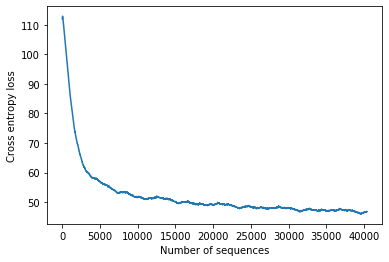

In [12]:
model.plot_losses()

In [13]:
prediction = model.predict('Gefeliciteerd', 50)
print(''.join(prediction))

Gefeliciteerdreet di good er rat: "Ne oog achten schooan van zi


References:
* Fundamentals of Recurrent Neural Network (RNN) and Long Short-Term Memory (LSTM) Network 	Elsevier "Physica D: Nonlinear Phenomena" journal, Volume 404, March 2020: Special Issue on Machine Learning and Dynamical Systems (DOI: 	10.1016/j.physd.2019.132306)
* https://www.kdnuggets.com/2020/07/rnn-deep-learning-sequential-data.html
* https://gist.github.com/karpathy/d4dee566867f8291f086